Tutorial 7: Adaptive Pixelization
=================================

In this tutorial we'll use a new `Pixelization`, called the VoronoiMagnification `Pixelization`. This pixelization
doesn`t use a uniform `Grid2D` of rectangular pixels, but instead uses an irregular `Voronoi` pixels. So, why do we
want to do that? Lets take another quick look at the rectangular grid..

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

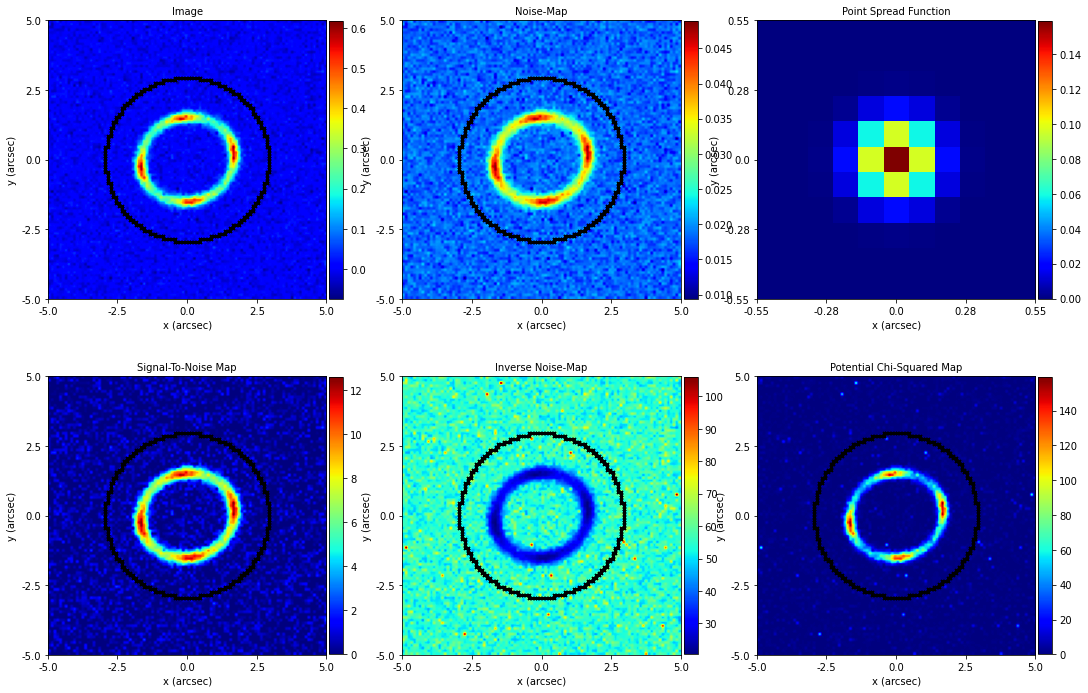

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.0,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

The lines of code below do everything we're used to, that is, setup an image, mask it, trace it via a tracer, 
setup the rectangular mapper, etc.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


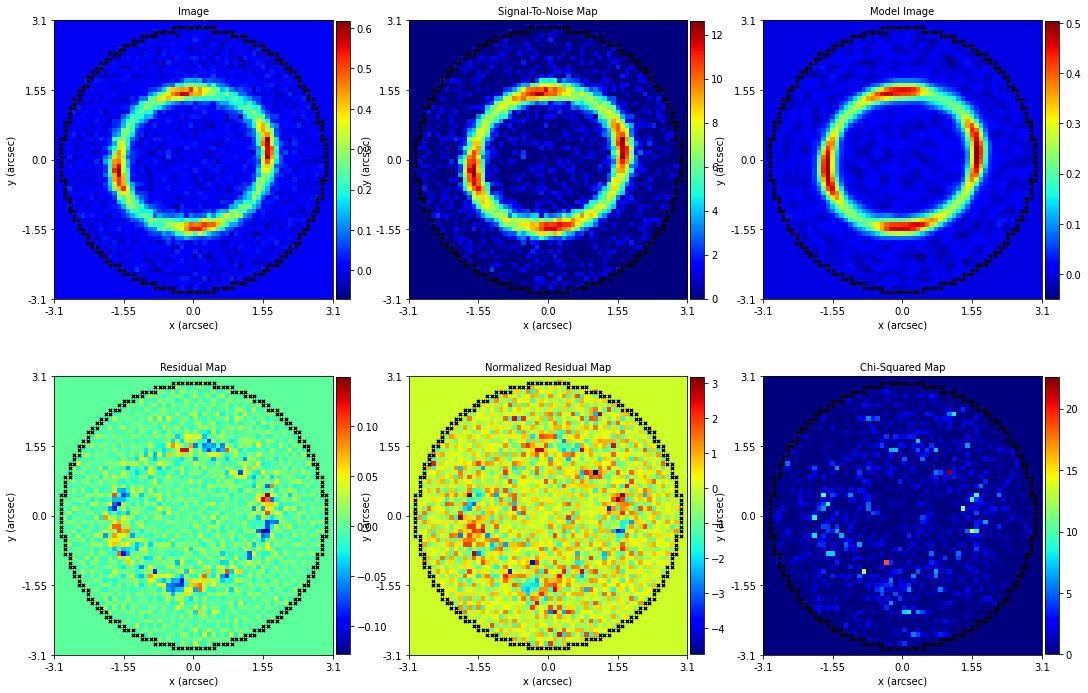

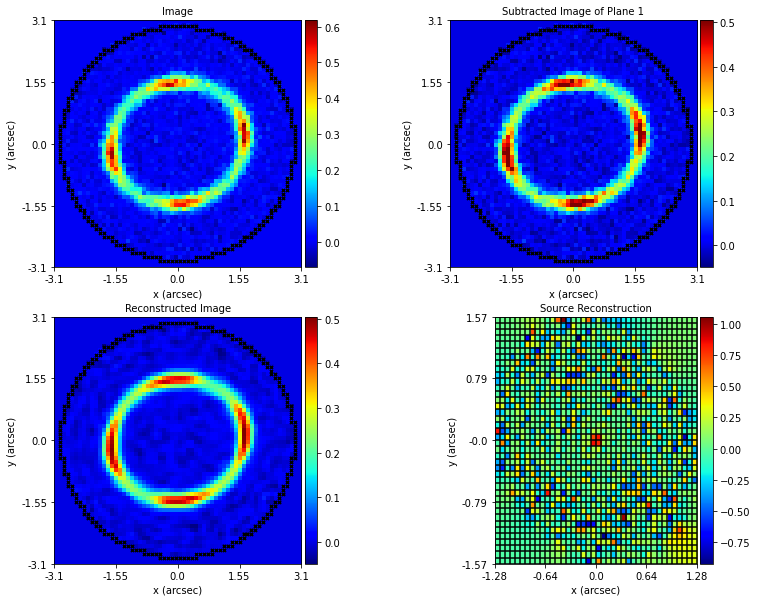

In [3]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

masked_imaging = al.MaskedImaging(
    imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=2)
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=0.5),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

Okay, so lets think about the `Rectangular` `Pixelization`. Is this the optimal way to reconstruct our source? Are 
there features in the source-plane that arn`t ideal? How do you think we could do a better job?

Well, given we're doing a whole tutorial on using a different `Pixelization` to this grid, you`ve probably guessed that
it isn't optimal. Infact, its pretty rubbish, and not a `Pixelization`.e should actually want to model any lenses with!

So what is wrong with the grid? Well, lets think about the source reconstruction.

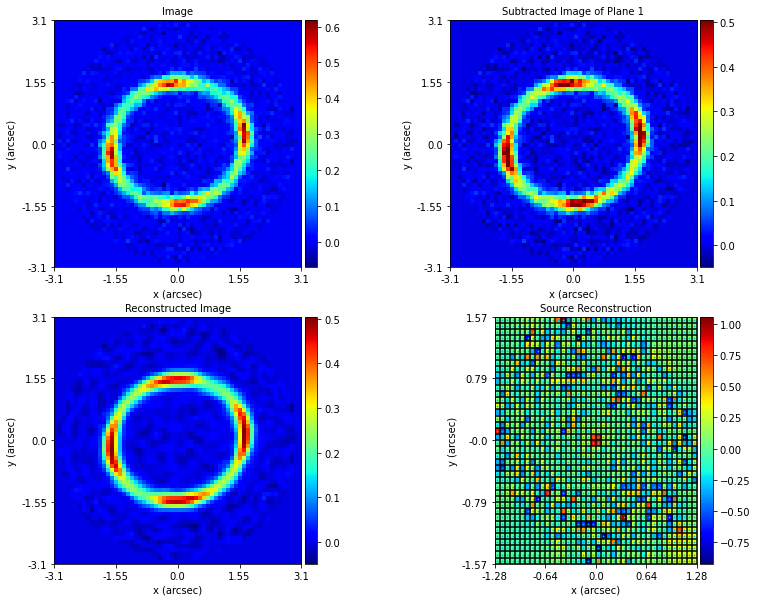

In [4]:
include_2d = aplt.Include2D(mapper_source_pixelization_grid=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

There is one clear problem, we are using a small number of the total source pixels to reconstruct the source. The 
majority of source pixels are located away from the source. By my estimate, we're using just 16 pixels (the central 
4x4 grid) out of the 1600 pixels to actually fit the data! The remaining ~1500 pixels are doing *nothing* but fit noise.

This is a waste and our analysis will take longer to run because of it. However, more importantly, it means that our 
Bayesian `Regularization` scheme is sub-optimal. In tutorial 4, we discussed how the Bayesian log evidence of the 
regularization wants to obtain the *simplest* source solution possible. That is the solution which fits the data 
well using the fewest source pixels. Clearly, if we dedicating a huge number of source pixels to doing *nothing*, our 
source reconstruction will be unecessarily complex (and therefore lower log_evidence).

If our `Pixelization` could `focus` its pixels where we actually have more data, e.g. the highly magnified regions of 
the source-plane, we could reconstruct the source using far fewer pixels. That`d be great both for computational 
efficiency and increasing the Bayesian log evidence. This is what the Voronoi `Pixelization` does.

To achieve this, we first compute an `image-plane sparse grid`, which is a set of sparse coordinates in the image-plane 
that will be ray-traced to the source-plane and define the centres of our source-pixel grid. We compute this `Grid2D` 
directly from a `Pixelization`, by passing it a grid.

In [5]:
adaptive = al.pix.VoronoiMagnification(shape=(20, 20))

image_plane_sparse_grid = adaptive.sparse_grid_from_grid(grid=masked_imaging.grid)

We can plot this `Grid2D` over the image, to see that it is a coarse `Grid2D` over-laying the image itself.

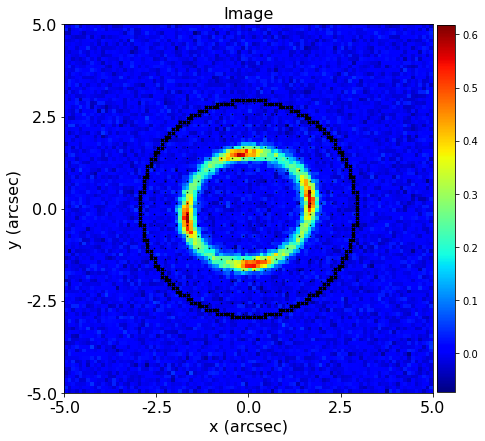

In [6]:
visuals_2d = aplt.Visuals2D(grid=image_plane_sparse_grid, mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures(image=True)

When we pass a `Tracer` a source galaxy with this `Pixelization` it automatically computes the ray-traced source-plane 
Voronoi `Pixelization` using the `Grid2D` above. Thus, our Voronoi `Pixelization`.s used by the tracer`s fit.

In [7]:
source_galaxy = al.Galaxy(
    redshift=1.0, pixelization=adaptive, regularization=al.reg.Constant(coefficient=1.0)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

If we look at the lens fit, we'll see that our source-plane no longer uses rectangular pixels, but Voronoi pixels!

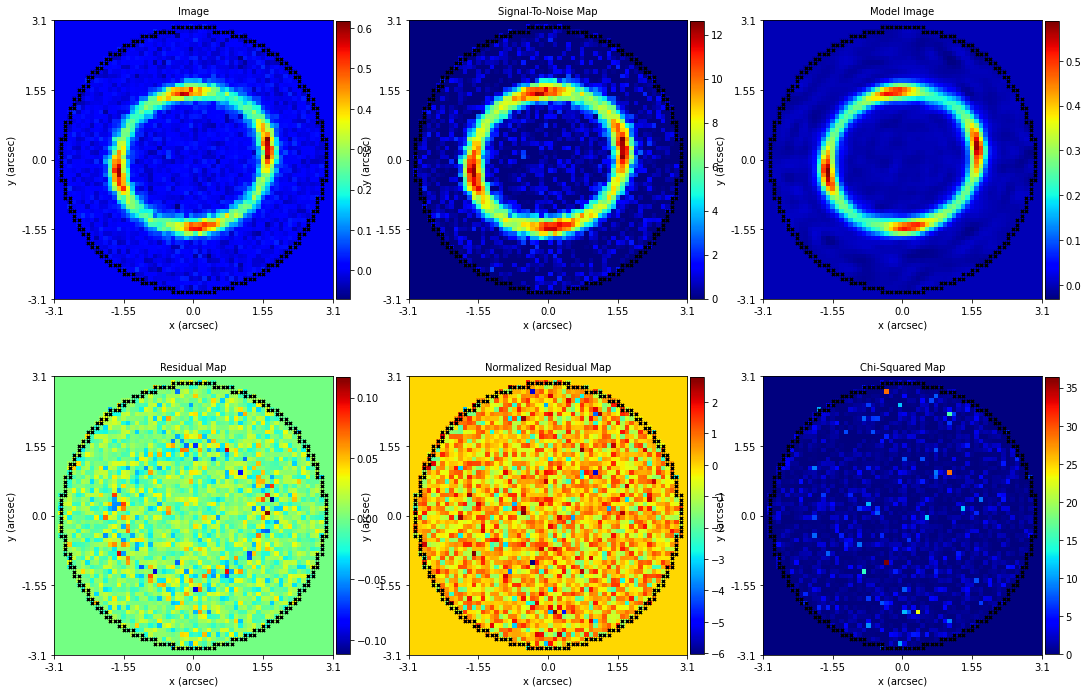

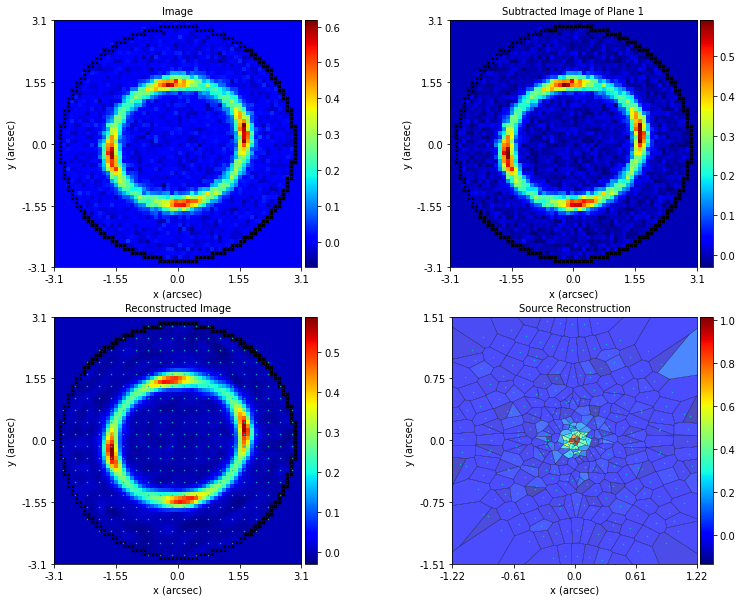

In [8]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(
    mask=True, mapper_data_pixelization_grid=True, mapper_source_pixelization_grid=True
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

And we can take a closer inspection of the `Inversion` itself.

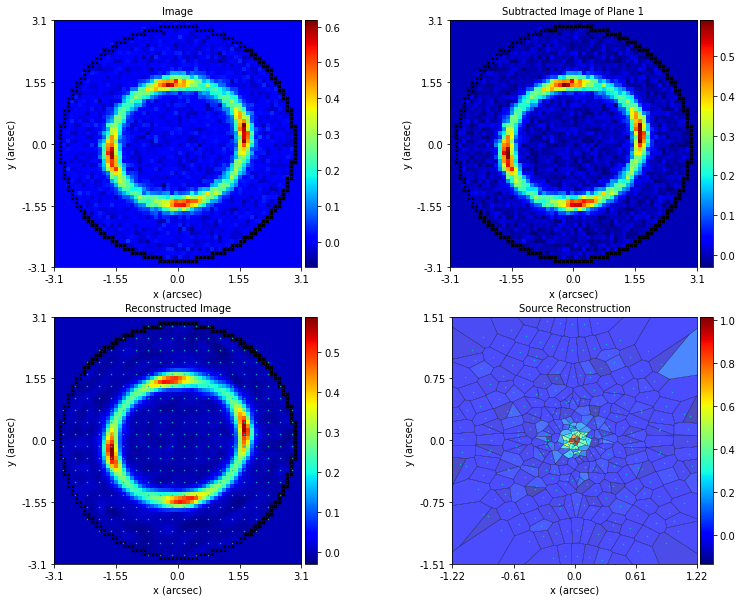

In [9]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

Clearly, this is an improvement. we're using fewer pixels than the rectangular `Grid2D` (400, instead of 1600), but 
reconstructing our source is far greater detail. A win all around? It sure is.

On our rectangular grid, we regularized each source pixel with its 4 neighbors. We compared their fluxes, summed 
the differences, and penalized solutions where the differences were large. For a Voronoi `Pixelization`, we do the same 
thing, now comparing each source-pixel with all other source-pixels with which it shares a direct vertex. This means that 
different source-pixels may be regularized with different numbers of source-pixels, depending on how many neighbors 
are formed.

However, this `VoronoiMagnification` `Pixelization`.is still far from optimal. There are lots of source-pixels 
effectively fitting just noise. We may achieve even better solutions if the central regions of the source were 
reconstructed using even more pixels. So, how do we improve on this? Well, you'll have to wait until chapter 5, 
when we introduce **PyAutoLens**`s adaptive functionality, or `hyper-mode`.

In the mean time, you may wish to experiment with using both Rectangular and VoronoiMagnification `Grid2D`'s to fit 
lenses which can be easily achieve by changing the input pixeliation given to a pipeline.